In [1]:
import uproot
import numpy as np
import pandas as pd

In [2]:
input_file = "/Users/ploskon/devel/jewel_project/eventfiles/PbPb_lund_200GeV.root"

In [3]:
df_events = uproot.open(input_file)["event_info"].arrays(library="pd")
df_tracks = uproot.open(input_file)["tracks"].arrays(library="pd")

In [4]:
df_events.head()

,eventID,weight,xsec
0,0.0,2.172660e-13,357.460999
1,1.0,1.992140e-12,341.791992
2,2.0,8.453220e-13,510.057007
3,3.0,4.162010e-13,404.201996
4,4.0,1.784940e-12,410.167999


In [5]:
df_tracks.head()

,eventID,label,px,py,pz,energy
0,0.0,211.0,0.111455,-0.161925,-117.398003,117.398003
1,0.0,22.0,-0.000144,-0.070827,57.999500,57.999500
2,0.0,22.0,0.054620,0.037013,126.836998,126.836998
3,0.0,-2112.0,-0.011232,-0.047440,1.111823,1.112892
4,0.0,3122.0,0.001742,0.174470,1.335099,1.346452


In [6]:
import yasp

import heppyy.util.fastjet_cppyy
import heppyy.util.pythia8_cppyy
import heppyy.util.heppyy_cppyy

from cppyy.gbl import fastjet as fj
from cppyy.gbl.std import vector

from yasp import GenericObject
import math

# make a singleton class for JetAlgoHelper
class JetAlgoHelper(object):
	_instance = None

	@staticmethod
	def get_instance():
		if JetAlgoHelper._instance is None:
			JetAlgoHelper()
		return JetAlgoHelper._instance

	def __init__(self):
		if JetAlgoHelper._instance is not None:
			raise Exception("This class is a singleton!")
		else:
			JetAlgoHelper._instance = self
			self.jet_def_wta = fj.JetDefinition(fj.cambridge_algorithm, 1.0)
			self.jet_def_wta.set_recombination_scheme(fj.WTA_pt_scheme)
			self.reclusterer_wta 	= fj.contrib.Recluster(self.jet_def_wta)
			self.sd01 = fj.contrib.SoftDrop(0, 0.1, 1.0)
			self.sd02 = fj.contrib.SoftDrop(0, 0.2, 1.0)
			self.lund_gen = fj.contrib.LundGenerator()
			print('[i] creating LundGenerator:', self.lund_gen)

	@classmethod
	def angularity(self, jet, a, k, jetR):
		ang = 0.0
		for p in jet.constituents():
			dr = jet.delta_R(p) / jetR
			pt = p.perp() / jet.perp()
			ang += ((dr)**a) * ((pt)**k)
		return ang

	def mass(self, jet):
		m2 = jet.e()**2 - jet.px()**2 - jet.py()**2 - jet.pz()**2
		if m2 > 0:
			return math.sqrt(m2)
		return 0.0

	def lund_delta_kt(self, jet):
		return [[l.Delta(), l.kt()] for l in self.lund_gen.result(jet)]

	def lund_log(self, jet):
		return [[math.log(1./l.Delta()), math.log(l.kt())] for l in self.lund_gen.result(jet)]

	def lunds_dict_list(self, jet):
		lunds = []
		for i, l in enumerate(self.lund_gen.result(jet)):
			lunds.append({'i': i, 'pt': l.pair().perp(), 
                 		'pt1': l.harder().perp(), 'pt2': l.softer().perp(), 'eta': l.pair().eta(), 
                   	'kt': l.kt(), 'delta': l.Delta(), 'kappa': l.kappa(), 'psi': l.psi(), 'z': l.z(), 'm': l.m()})
		return lunds

class LundJet(GenericObject):
	def __init__(self, jet, jetR, label=None, **kwargs):
		super().__init__(**kwargs)
		self.jet = jet
		self.pt = jet.pt()
		self.eta = jet.eta()
		self.y = jet.rap()
		self.phi = jet.phi()
		self.e = jet.e()
		self.m = jet.m()
		self.nconst = jet.constituents().size()
		self.jetR = jetR
		self.label = label

		self._jalgo = JetAlgoHelper.get_instance()

		self.jet_wta 	= self._jalgo.reclusterer_wta.result(jet)
		self.jet_sd01 = self._jalgo.sd01.result(jet)
		self.jet_sd02 = self._jalgo.sd02.result(jet)
		self.wtastd 	= self.jet_wta.delta_R(jet)
		self.wtasd01 	= self.jet_sd01.delta_R(jet)
		self.wtasd02 	= self.jet_sd02.delta_R(jet)
		self.angk1a1 	= self._jalgo.angularity(jet, 1.0, 1.0, self.jetR)
		self.angk1a2 	= self._jalgo.angularity(jet, 2.0, 1.0, self.jetR)
		self.angk1a3 	= self._jalgo.angularity(jet, 3.0, 1.0, self.jetR)
		self.mjet 		= self._jalgo.mass(jet)
		# self.lund_delta_kt = self._jalgo.lund_delta_kt(jet)
		# self.lund_log = self._jalgo.lund_log(jet)
		self.lunds = self._jalgo.lunds_dict_list(jet)

		self._base_props_list = []
		self._base_props_list = self._gen_base_props_list()

	def _gen_base_props_list(self):
		_g0 = GenericObject()
		l = [a for a in _g0.__dict__]
		_ = [l.append(a) for a in self.__dict__ if a[0] == '_' and a not in l]
		return l

	def to_dict(self):
		# Convert the object to a dictionary
		d = {}
		for key in self.__dict__:
			if key not in self._base_props_list:
				d[key] = getattr(self, key)
		return d

	def to_basic_type_dict(self):
		# Convert the object to a dictionary
		d = {}
		for key in self.__dict__:
			if key not in self._base_props_list:
				o = getattr(self, key)
				if isinstance(o, fj.PseudoJet):
					d[key] = [o.px(), o.py(), o.pz(), o.e()]
				else:
					d[key] = getattr(self, key)
		return d

/Users/ploskon/devel/yasp/software/bundle/hepbase/root/default/lib/cppyy_backend/loader.py:90: UserWarning: No precompiled header available (/Users/ploskon/devel/yasp/software/bundle/hepbase/root/default/lib/cppyy_backend/etc not writable); this may impact performance.
  warnings.warn('No precompiled header available (%s); this may impact performance.' % msg)
[yasp-i] Running in Jupyter: True


In [7]:
def lund_jets(df, include_groups=True, label=''):
  jets_dicts = []
  parts = vector[fj.PseudoJet]([fj.PseudoJet(p.px, p.py, p.pz, p.energy) for p in df.itertuples()])
  jet_def = fj.JetDefinition(fj.antikt_algorithm, 0.4)
  cluster_seq = fj.ClusterSequence(parts, jet_def)
  jets = fj.sorted_by_pt(cluster_seq.inclusive_jets())
  
  for j in jets:
    jet = LundJet(jet=j, jetR=0.4, label=label)
    jets_dicts.append(jet.to_basic_type_dict())
  
  return pd.DataFrame(jets_dicts)

In [8]:
df_lunds = pd.merge(df_events, df_tracks, on="eventID").groupby("eventID").apply(lund_jets, include_groups=False, label='PbPb').reset_index(drop=True)
df_lunds.to_parquet('saved_lunds.parquet', engine="pyarrow")

#--------------------------------------------------------------------------
#                         FastJet release 3.5.1
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           https://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code
# and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
[i] creating LundGenerator: @0x350c59ee0
#----------------------------------

In [9]:
!ls -ltr *.parquet

-rw-r--r--@ 1 ploskon  staff      19033 May 14 18:32 jets.parquet
-rw-r--r--@ 1 ploskon  staff   14620522 May 16 19:18 pythia_lund_jet_unlabelled.parquet
-rw-r--r--@ 1 ploskon  staff   15039365 May 19 14:22 lund_jet_hardQCDbeauty.parquet
-rw-r--r--@ 1 ploskon  staff   14961016 May 19 14:22 lund_jet_hardQCDcharm.parquet
-rw-r--r--@ 1 ploskon  staff   14231883 May 19 14:23 lund_jet_hardQCDquarks.parquet
-rw-r--r--@ 1 ploskon  staff   14621070 May 19 14:23 lund_jet_hardQCDany.parquet
-rw-r--r--@ 1 ploskon  staff   14711110 May 19 14:23 lund_jet_hardQCDlf.parquet
-rw-r--r--@ 1 ploskon  staff   14815345 May 19 14:23 lund_jet_hardQCDgluons.parquet
-rw-r--r--@ 1 ploskon  staff      28018 May 20 16:16 pythia_lund_jet.parquet
-rw-r--r--@ 1 ploskon  staff      29788 May 20 16:16 pythia_lund_jet_emb.parquet
-rw-r--r--@ 1 ploskon  staff  309046093 Jul 24 01:16 saved_lunds.parquet


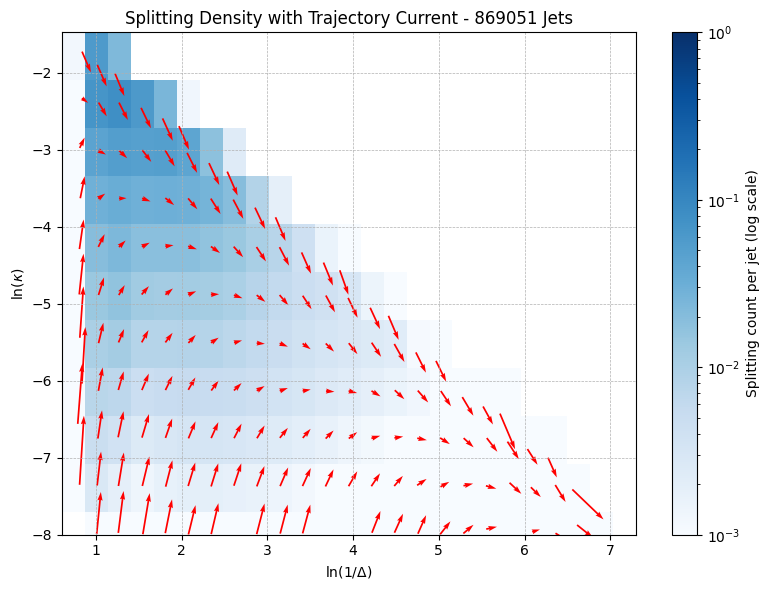

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Load your parquet file
df_jets = pd.read_parquet('saved_lunds.parquet')

s_kt_or_kappa = 'kt'
s_kt_or_kappa = 'kappa'

# Extract lund records from all jets
records = []
for _, row in df_jets.iterrows():
    lunds = row['lunds']
    for i in range(len(lunds) - 1):
        kt_i, delta_i = lunds[i][s_kt_or_kappa], lunds[i]['delta']
        kt_j, delta_j = lunds[i+1][s_kt_or_kappa], lunds[i+1]['delta']
        x_i, y_i = np.log(1/delta_i), np.log(kt_i)
        x_j, y_j = np.log(1/delta_j), np.log(kt_j)
        records.append({'x': x_i, 'y': y_i, 'dx': x_j - x_i, 'dy': y_j - y_i})

df = pd.DataFrame(records)

# Define grid and bin the (x,y) positions
nx, ny = 25, 25
x_bins = np.linspace(df['x'].min(), df['x'].max(), nx + 1)
y_bins = np.linspace(df['y'].min(), df['y'].max(), ny + 1)
df['ix'] = pd.cut(df['x'], bins=x_bins, labels=False, include_lowest=True)
df['iy'] = pd.cut(df['y'], bins=y_bins, labels=False, include_lowest=True)

# Compute average displacement per bin
group = (
    df.groupby(['ix', 'iy'])
      .agg(x=('x', 'mean'), y=('y', 'mean'),
           dx=('dx', 'mean'), dy=('dy', 'mean'))
      .dropna()
      .reset_index()
)

y_limit_low = df['y'].min()
y_limit_low = -8
if s_kt_or_kappa == 'kt':
    # Apply cut for plotting only (ln(kT) > -4)
    y_limit_low = -4

df_plot = df[df['y'] > y_limit_low]
group_plot = group[group['y'] > y_limit_low]

plt.figure(figsize=(8, 6))

# 1) density background (only for ln(kT) > -4)
weights_plot = np.ones_like(df_plot['x']) / len(df_jets)
plt.hist2d(
    df_plot['x'], df_plot['y'],
    bins=[x_bins, y_bins],
    cmap='Blues',
    norm=mcolors.LogNorm(),
    weights=weights_plot
)
plt.clim(0.001, 1.0)
plt.colorbar(label='Splitting count per jet (log scale)')

# 2) trajectory current (quiver only for arrows starting at ln(kT) > -4)
plt.quiver(group_plot['x'], group_plot['y'], group_plot['dx'], group_plot['dy'], 
           angles='xy', scale_units='xy', scale=5, width=0.003, color='red', alpha=1.0)

plt.xlabel(r'$\ln(1/\Delta)$')
ylabel_latex = r'$\ln(k_T)$' if s_kt_or_kappa == 'kt' else r'$\ln(\kappa)$'
plt.ylabel(ylabel_latex)
plt.ylim(y_limit_low, None)
plt.title(f'Splitting Density with Trajectory Current - {len(df_jets)} Jets')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()